In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
asset_type = "all"

metrics = {
    "median": "unit_price_median",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = f"median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [43]:
def drop_invalid_rows(df):
    return df[~df[metric_pct_chg].isna()].reset_index(drop=True)

In [44]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

all_years = list(range(start_year, eval_end_year + 1))
train_years = list(range(start_year, eval_start_year))
eval_years = list(range(eval_start_year, eval_end_year + 1))

yearly_dataframes = {
    f"{year}": drop_invalid_rows(df[df["year"] == year]) for year in all_years
}

cumulative_yearly_dataframes = {
    f"{year}": drop_invalid_rows(df[df["year"].between(start_year, year)]) for year in all_years
}

# Set up extra dataframes for evaluation
for i in range(1, years_ahead + 1):
    yearly_dataframes[f"{eval_end_year + i}"] = (
        yearly_dataframes[f"{eval_end_year}"][["area", "area_code", "asset_type"]]
        .drop_duplicates()
        .assign(year=eval_end_year + i)
    )

combined_eval_df = drop_invalid_rows(df[df["year"] >= eval_start_year])

# Finally
df = df.fillna(0)

In [45]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "yearly_price_growth",
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [46]:
BATCH_SIZE = 256

In [47]:
yearly_datasets = {
    f"{year}": JapanRETimeSeriesDataset(
        df,
        cumulative_yearly_dataframes[f"{year}"],
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        weight_column="weight",
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
        shift=years_ahead,
    )
    for year in all_years
}

yearly_dataloaders = {
    f"{year}": DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
    )
    for year, train_dataset in yearly_datasets.items()
}

combined_eval_dataset = JapanRETimeSeriesDataset(
    df,
    combined_eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

combined_eval_dataloader = DataLoader(
    combined_eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [48]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [49]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [50]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs_per_year = 7

In [24]:
# Incremental training and evaluation (Eval years = [2021, 2022])
progress_bar = None
save_predictions = True

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

for year in all_years:
    print(f"-----------------")
    print(f" Year: {year}")
    print(f"-----------------")

    model = TimeSeriesTransformerModel(
        n_features=n_features,
        d_model=d_model,
        nhead=nhead,
        d_hid=d_hid,
        nlayers=nlayers,
        dropout=dropout,
        enc_dropout=enc_dropout,
        device=device,
    )
    model = model.to(device)

    train_dataloader = yearly_dataloaders[f"{year}"]
    num_training_steps = num_epochs_per_year * len(train_dataloader)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    lr_scheduler = get_scheduler(
        "linear",  # constant
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(num_epochs_per_year):
        train_loss, train_r2_score = train_weighted(
            model,
            train_dataloader,
            optimizer,
            lr_scheduler,
            progress_bar,
            device=device,
        )
        train_losses.append(train_loss)
        train_r2_scores.append(train_r2_score)

        eval_loss, eval_r2_score = evaluate_weighted(
            model, combined_eval_dataloader, device=device
        )
        eval_losses.append(eval_loss)
        eval_r2_scores.append(eval_r2_score)

        print(f" Epoch: {epoch}")
        print(f" Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
        print(f" Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")
        # The final two years will have overlap, so ignore those
    
    if save_predictions:
        # Even predicts for 2023 and 2024
        # Predict returns n years ahead
        output_dataset_name = f"{dataset_name}_{year + years_ahead}"
        model_output_data_path = model_output_data_paths[output_dataset_name]
        prediction_df = yearly_dataframes[f"{year + years_ahead}"]

        prediction_df["predicted_normalized_return"] = predict_returns(
            model,
            df,
            prediction_df,
            metric,
            feature_columns,
            device=device,
        )

        prediction_df[
            [
                "year",
                "area_code",
                "asset_type",
                "predicted_normalized_return",
                "yearly_price_growth",
                metric_pct_chg,
                normalized_metric_pct_chg,
            ]
        ].to_csv(model_output_data_path, index=False)

-----------------
 Year: 2007
-----------------
 Epoch: 0
 Train Loss: 9.1355, Eval Loss: 13.8404
 Train R^2: -0.0657, Eval R^2: -0.6325
 Epoch: 1
 Train Loss: 16.6398, Eval Loss: 8.6167
 Train R^2: -0.7939, Eval R^2: -0.1033
 Epoch: 2
 Train Loss: 9.1101, Eval Loss: 7.3904
 Train R^2: -0.0798, Eval R^2: 0.0021
 Epoch: 3
 Train Loss: 7.6806, Eval Loss: 8.1757
 Train R^2: 0.0764, Eval R^2: -0.0947
 Epoch: 4
 Train Loss: 9.5574, Eval Loss: 8.4488
 Train R^2: -0.0895, Eval R^2: -0.1257
 Epoch: 5
 Train Loss: 9.4636, Eval Loss: 8.2631
 Train R^2: -0.0877, Eval R^2: -0.1037
 Epoch: 6
 Train Loss: 9.4483, Eval Loss: 8.0712
 Train R^2: -0.0809, Eval R^2: -0.0813
-----------------
 Year: 2008
-----------------
 Epoch: 0
 Train Loss: 14.6640, Eval Loss: 13.3929
 Train R^2: -0.6470, Eval R^2: -0.6931
 Epoch: 1
 Train Loss: 11.5007, Eval Loss: 8.2978
 Train R^2: -0.3383, Eval R^2: -0.1048
 Epoch: 2
 Train Loss: 8.5250, Eval Loss: 7.4127
 Train R^2: -0.0071, Eval R^2: 0.0024
 Epoch: 3
 Train Loss:

KeyboardInterrupt: 

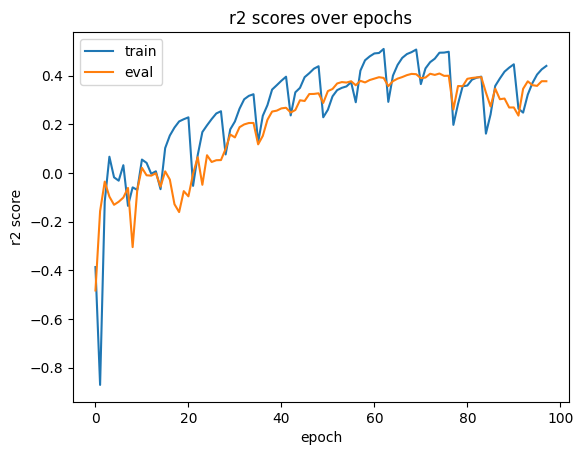

In [ ]:
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

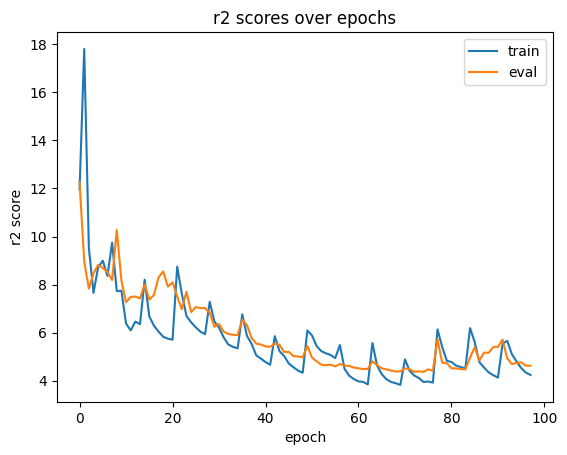

In [ ]:
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

In [ ]:
output_dataset_name = f"{dataset_name}_{year + years_ahead}"
model_output_data_path = model_output_data_paths[output_dataset_name]
prediction_df = yearly_dataframes[f"{year + years_ahead}"]

prediction_df["predicted_normalized_return"] = predict_returns(
    model,
    df,
    prediction_df,
    metric,
    feature_columns,
    device=device,
)

In [18]:
# Predictions for backtesting
progress_bar = None
save_predictions = True

for year in all_years:
    print(f"-----------------")
    print(f" Year: {year}")
    print(f"-----------------")

    # Train on year
    train_dataloader = yearly_dataloaders[f"{year}"]
    num_training_steps = num_epochs_per_year * len(train_dataloader)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    lr_scheduler = get_scheduler(
        "linear",  # constant
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(num_epochs_per_year):
        train_loss, train_r2_score = train_weighted(
            model,
            train_dataloader,
            optimizer,
            lr_scheduler,
            progress_bar,
            device=device,
        )

        eval_loss, eval_r2_score = evaluate_weighted(
            model, combined_eval_dataloader, device=device
        )

        print(f" Epoch: {epoch}")
        print(f" Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
        print(f" Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

    if save_predictions:
        # Even predicts for 2023 and 2024
        # Predict returns n years ahead
        output_dataset_name = f"{dataset_name}_{year + years_ahead}"
        model_output_data_path = model_output_data_paths[output_dataset_name]
        prediction_df = yearly_dataframes[f"{year + years_ahead}"]

        prediction_df["predicted_normalized_return"] = predict_returns(
            model,
            df,
            prediction_df,
            metric,
            feature_columns,
            device=device,
        )

        prediction_df[
            [
                "year",
                "area_code",
                "asset_type",
                "predicted_normalized_return",
                "yearly_price_growth",
                metric_pct_chg,
                normalized_metric_pct_chg,
            ]
        ].to_csv(model_output_data_path, index=False)


-----------------
 Year: 2007
-----------------
 Epoch: 0
 Train Loss: 10.7722, Eval Loss: 13.3513
 Train R^2: -0.1860, Eval R^2: -0.7362
 Epoch: 1
 Train Loss: 11.6440, Eval Loss: 10.8930
 Train R^2: -0.3701, Eval R^2: -0.4160
 Epoch: 2
 Train Loss: 9.6482, Eval Loss: 8.5375
 Train R^2: -0.1481, Eval R^2: -0.1092
 Epoch: 3
 Train Loss: 7.6989, Eval Loss: 7.8604
 Train R^2: 0.0595, Eval R^2: -0.0042
 Epoch: 4
 Train Loss: 7.2873, Eval Loss: 7.9081
 Train R^2: 0.1177, Eval R^2: 0.0040
 Epoch: 5
 Train Loss: 7.3081, Eval Loss: 7.9980
 Train R^2: 0.1235, Eval R^2: -0.0022
 Epoch: 6
 Train Loss: 7.5862, Eval Loss: 8.0096
 Train R^2: 0.0861, Eval R^2: -0.0038
-----------------
 Year: 2008
-----------------
 Epoch: 0
 Train Loss: 9.6058, Eval Loss: 8.4441
 Train R^2: -0.0663, Eval R^2: -0.0906
 Epoch: 1
 Train Loss: 7.1490, Eval Loss: 8.8924
 Train R^2: -0.0087, Eval R^2: -0.0834
 Epoch: 2
 Train Loss: 7.7390, Eval Loss: 8.5207
 Train R^2: -0.0474, Eval R^2: -0.0435
 Epoch: 3
 Train Loss: 7.

KeyboardInterrupt: 

In [38]:
# Naive Backtesting

# Say we have a 1000 dollars
# At year 1, we select the top 20 areas predicted by the model
# We invest 50 dollars in each area
# At year 2, we dispose all and rebalance

"""
cash = 1000
assets = {}


For every second year:
    actual_returns = get_returns(year)
    assets = {
        area: value * ( 1 + actual_returns[area] )
        for area, value in assets.items()
    }
    nav = sum(assets.values())
    print(nav)

    returns = predict_returns(building)
    top_n = get_n_largest(returns)
    assets = {
        area: cash * ( 1 / n )
        for area in top_n
    }
    cash = 0




"""



'\ncash = 1000\nassets = {}\n\n\nFor every second year:\n    actual_returns = get_returns(year)\n    assets = {\n        area: value * ( 1 + actual_returns[area] )\n        for area, value in assets.items()\n    }\n    nav = sum(assets.values())\n    print(nav)\n\n    returns = predict_returns(building)\n    top_n = get_n_largest(returns)\n    assets = {\n        area: cash * ( 1 / n )\n        for area in top_n\n    }\n    cash = 0\n\n\n\n\n'

In [ ]:
investment_start_year = 2012
investment_end_year = 2020
investment_eval_end_year = 2022

asset_type = "building"

asset_count = 20
shorting_enabled = True
cash, assets, liabilities = 1000, {}, {}

# Reinvest all earnings: cash * ( 1 / 20 )

for year in range(investment_start_year, investment_eval_end_year):
    current_year_df = pd.read_csv(model_output_data_paths[f"{dataset_name}_{year}"])
    current_year_df = current_year_df[current_year_df["asset_type"] == "building"]
    current_year_df = current_year_df.set_index('area_code')

    assets = {
        area_code: value * ( 1 + current_year_df.loc[area_code, "yearly_price_growth"] )
        for area_code, value in assets.items()
    } 
    liabilities = {
        area_code: value * ( 1 + current_year_df.loc[area_code, "yearly_price_growth"] )
        for area_code, value in assets.items()
    }

    nav = sum(assets.values() - liabilities.values()) + cash

    if year <= investment_end_year:
        # Close Positions
        cash, assets, liabilities = nav, {}, {}

        # Rebalance
        prediction_year_df = pd.read_csv(model_output_data_paths[f"{dataset_name}_{year + years_ahead}"])
        prediction_year_df = prediction_year_df[prediction_year_df["asset_type"] == "building"]
        prediction_year_df = prediction_year_df.set_index('area_code')

        top_areas = prediction_year_df.nlargest(asset_count, "predicted_normalized_return").index
        bottom_areas = prediction_year_df.nsmallest(asset_count, "predicted_normalized_return").index

        # Invest
        assets = {
            area_code: cash * ( 1 / asset_count )
            for area_code in top_areas
        }
        cash -= sum(assets.values())

        # Short
        if shorting_enabled:
            liabilities = {
                area_code: cash * ( 1 / asset_count )
                for area_code in bottom_areas
            }
            cash += sum(liabilities.values())
        



In [ ]:
# When I'm predicting 2022, I want a model trained only on 2020 and before
